In [21]:
import numpy as np
from skimage import io, color
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio

### Importing one image

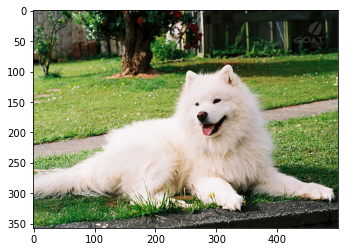

In [2]:
path = './samoyed-data/'
name = 'samoyed-10.jpg'
img = io.imread(path+name)
plt.imshow(img, cmap = 'gray')
plt.show()


### adding some noises

In [3]:
def addNoise(img, sigma=0.05):
    h,w,d = img.shape
    noisy_img = np.copy(img)
    for i in range(d):
         noisy_img[:,:,i] += np.array(sigma*np.random.randn(h,w)*255,dtype = 'uint8')
    return noisy_img

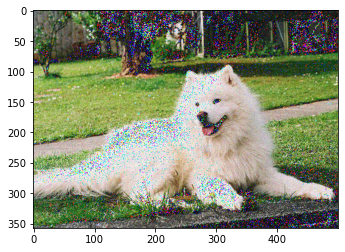

In [4]:
sigma=0.05 #std of noise added on original image
noisy_img = addNoise(img)
plt.imshow(noisy_img)
plt.show()

In [41]:
def nonLocalMeans(noisy,bigWindowSize, smallWindowSize, h, diag = True):
    
    padwidth = bigWindowSize//2
    image = noisy.copy()
    
    h,w = image.shape
    
    # creates a padded image that reflects the border so that the big window can be accomodated through the loop
    paddedImg = np.zeros((h + bigWindowSize,w + bigWindowSize))
    paddedImg = paddedImg.astype(np.uint8)
    paddedImg[padwidth:padwidth+h, padwidth:padwidth+w] = image
    paddedImg[padwidth:padwidth+h, 0:padwidth] = np.fliplr(image[:,0:padwidth])
    paddedImg[padwidth:padwidth+h, w+padwidth:w+2*padwidth] = np.fliplr(image[:,w-padwidth:w])
    paddedImg[0:padwidth,:] = np.flipud(paddedImg[padwidth:2*padwidth,:])
    paddedImg[padwidth+h:2*padwidth+h, :] =np.flipud(paddedImg[paddedImg.shape[0] - 2*padwidth:paddedImg.shape[0] - padwidth,:])

    iter_ = 0
    tot_iter = image.shape[1]*image.shape[0]*(bigWindowSize - smallWindowSize)**2

    outputImg = paddedImg.copy()

    smallhalfwidth = smallWindowSize//2
    
    if diag:
        # For each pixel in the actual image, find a area around the pixel that needs to be compared
        for imageX in tqdm(range(padwidth, padwidth + image.shape[1])):
            for imageY in range(padwidth, padwidth + image.shape[0]):

                bWinX = imageX - padwidth
                bWinY = imageY - padwidth

                #comparison neighbourhood
                compNbhd = paddedImg[imageY - smallhalfwidth:imageY + smallhalfwidth + 1,imageX-smallhalfwidth:imageX+smallhalfwidth + 1]


                pixelColor = 0
                totalWeight = 0

                # For each comparison neighbourhood, search for all small windows within a large box, and compute their weights
                for sWinX in range(bWinX, bWinX + bigWindowSize - smallWindowSize, 1):
                    for sWinY in range(bWinY, bWinY + bigWindowSize - smallWindowSize, 1):   
                        #find the small box       
                        smallNbhd = paddedImg[sWinY:sWinY+smallWindowSize + 1,sWinX:sWinX+smallWindowSize + 1]
                        euclideanDistance = np.sqrt(np.sum(np.square(smallNbhd - compNbhd)))
                        #weight is computed as a weighted softmax over the euclidean distances
                        weight = np.exp(-euclideanDistance/h)
                        totalWeight += weight
                        pixelColor += weight*paddedImg[sWinY + smallhalfwidth, sWinX + smallhalfwidth]
                        iter_ += 1

                pixelColor /= totalWeight
                outputImg[imageY, imageX] = pixelColor
    else:
        # For each pixel in the actual image, find a area around the pixel that needs to be compared
        for imageX in range(padwidth, padwidth + image.shape[1]):
            for imageY in range(padwidth, padwidth + image.shape[0]):

                bWinX = imageX - padwidth
                bWinY = imageY - padwidth

                #comparison neighbourhood
                compNbhd = paddedImg[imageY - smallhalfwidth:imageY + smallhalfwidth + 1,imageX-smallhalfwidth:imageX+smallhalfwidth + 1]


                pixelColor = 0
                totalWeight = 0

                # For each comparison neighbourhood, search for all small windows within a large box, and compute their weights
                for sWinX in range(bWinX, bWinX + bigWindowSize - smallWindowSize, 1):
                    for sWinY in range(bWinY, bWinY + bigWindowSize - smallWindowSize, 1):   
                        #find the small box       
                        smallNbhd = paddedImg[sWinY:sWinY+smallWindowSize + 1,sWinX:sWinX+smallWindowSize + 1]
                        euclideanDistance = np.sqrt(np.sum(np.square(smallNbhd - compNbhd)))
                        #weight is computed as a weighted softmax over the euclidean distances
                        weight = np.exp(-euclideanDistance/h)
                        totalWeight += weight
                        pixelColor += weight*paddedImg[sWinY + smallhalfwidth, sWinX + smallhalfwidth]
                        iter_ += 1

                pixelColor /= totalWeight
                outputImg[imageY, imageX] = pixelColor

    return outputImg[padwidth:padwidth+h,padwidth:padwidth+w]


In [27]:
output_img = []
for i in range(3):
    output_img.append(nonLocalMeans(noisy_img[:,:,i],10,4,7))
output_img = np.array(output_img).transpose(1,2,0)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:26<00:00,  5.75it/s]


noisy psnr:  14.58787903292122 

denoised psnr 18.273764515261146


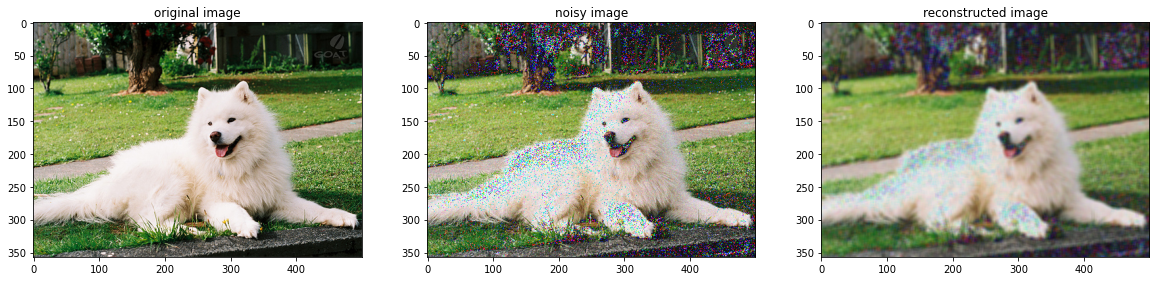

In [28]:
#Plotting results
plt.figure(figsize=(20,10))
plt.subplot(131)
plt.imshow(img)
plt.title("original image")
plt.subplot(132)
plt.imshow(noisy_img)
plt.title("noisy image")
plt.subplot(133)
plt.imshow(output_img)
plt.title("reconstructed image")

#Comparing psnr score
psnr_noisy=peak_signal_noise_ratio(img,noisy_img)
print("noisy psnr: ",psnr_noisy,"\n")
psnr_denoised=peak_signal_noise_ratio(img,output_img)
print("denoised psnr",psnr_denoised)

### Test over the whole dataset

In [46]:
def load_data(id):
    path = './samoyed-data/'
    name = 'samoyed-{}.jpg'.format(id)
    img = io.imread(path+name)
    return img

def NLM(bigWindowSize = 10, smallWindowSize = 4, h = 7, n = 50, sigma = 0.05):
    
    psnr_noisy = []
    psnr_denoised = []

    for id_img in tqdm(range(1,n+1)):
        img = load_data(id_img)
        noisy_img = addNoise(img,sigma)
        output_img = []
        for i in range(3):
            output_img.append(nonLocalMeans(noisy_img[:,:,i],bigWindowSize,smallWindowSize,h,False))
        output_img = np.array(output_img).transpose(1,2,0)
        psnr_noisy.append(peak_signal_noise_ratio(img,noisy_img))
        psnr_denoised.append(peak_signal_noise_ratio(img,output_img))
    return psnr_denoised,psnr_noisy

In [48]:
psnr_denoised,psnr_noisy = NLM(n = 10)

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [42:50<00:00, 257.06s/it]


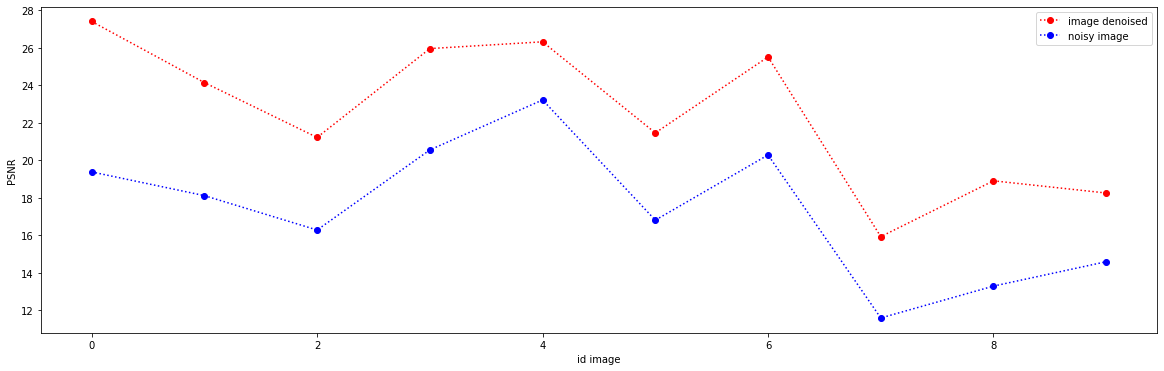

In [58]:
plt.figure(figsize=(20,6) )
plt.plot(psnr_denoised,'o:r', label='image denoised')
plt.plot(psnr_noisy,'o:b', label = 'noisy image')
plt.xlabel("id image")
plt.ylabel("PSNR")
plt.legend()
plt.show()